In [7]:
# Step 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.utils import resample

import warnings
warnings.filterwarnings('ignore')


In [9]:
# Step 2: Load Dataset
data = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
data.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


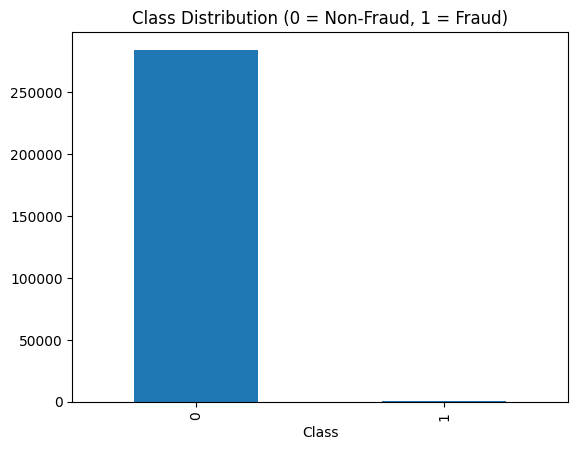

In [10]:
# Step 3: Class Distribution
data['Class'].value_counts().plot(kind='bar')
plt.title('Class Distribution (0 = Non-Fraud, 1 = Fraud)')
plt.show()


In [11]:
# Step 4: Feature Scaling and Cleanup
scaler = StandardScaler()
data['Amount_Scaled'] = scaler.fit_transform(data[['Amount']])
data.drop(['Amount', 'Time'], axis=1, inplace=True)


In [12]:
# Step 5: Train-Test Split
X = data.drop('Class', axis=1)
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


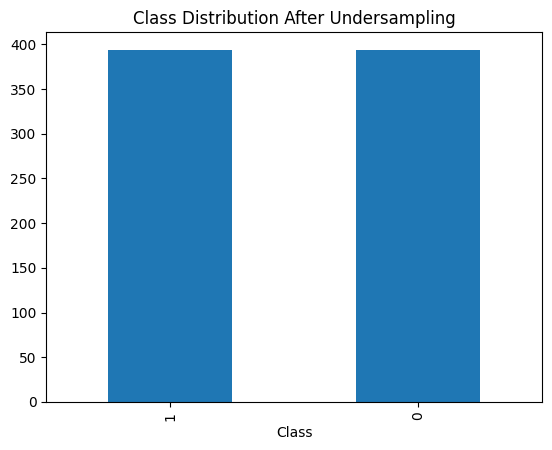

In [13]:
# Step 6: Handle Imbalance with Undersampling

# Combine back into single dataframe
train_data = pd.concat([X_train, y_train], axis=1)

# Separate minority and majority classes
fraud = train_data[train_data['Class'] == 1]
non_fraud = train_data[train_data['Class'] == 0]

# Downsample majority class
non_fraud_downsampled = resample(non_fraud, 
                                 replace=False,    
                                 n_samples=len(fraud), 
                                 random_state=42)

# Combine
downsampled = pd.concat([fraud, non_fraud_downsampled])

# Split features and target
X_train_res = downsampled.drop('Class', axis=1)
y_train_res = downsampled['Class']

# Check class balance
y_train_res.value_counts().plot(kind='bar')
plt.title('Class Distribution After Undersampling')
plt.show()


In [14]:
# Step 7: Train Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_res, y_train_res)


RandomForestClassifier(random_state=42)

In [15]:
# Step 8: Evaluation
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

roc_score = roc_auc_score(y_test, y_prob)
print(f'ROC-AUC Score: {roc_score:.4f}')


[[54781  2083]
 [    9    89]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.91      0.08        98

    accuracy                           0.96     56962
   macro avg       0.52      0.94      0.53     56962
weighted avg       1.00      0.96      0.98     56962

ROC-AUC Score: 0.9762


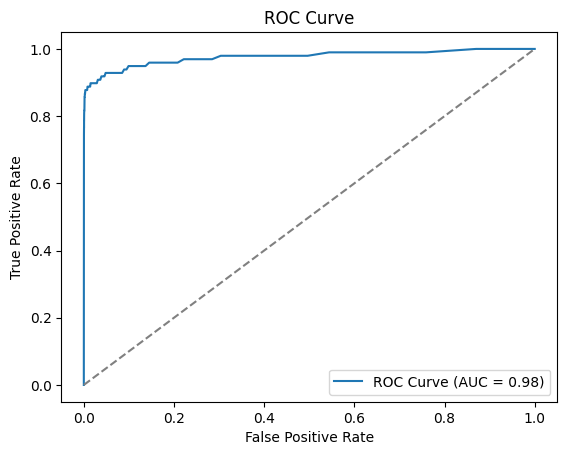

In [16]:
# Step 9: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_score:.2f})')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [17]:
from sklearn.metrics import accuracy_score

# Predictions
y_pred = model.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc*100:.2f}%")


Accuracy: 96.33%
